In [129]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt

from model import PModel, ADModel, PIP

#Global parameters for Pareto front
n_loci = 9      #Number of loci
p1 = 0.3        #Probability of first-order epistatic interaction
p2 = 0.3        #Probability of second-order epistatic interaction
sigma1 = 0.3    #Standard deviation for first-order epistasis
sigma2 = 0.3    #Standard deviation for second-order epistasis
beta = 0.005    #Baseline transmission rate

#Parameters for evolutionary simulation
n_gens = 15
t = (0, 1000)

In [130]:
#Initialize discrete random loci model
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

PF_model = PModel(n_loci, res, cost, beta=beta)
PF_model.normalize()

res_pareto, fec_pareto = PF_model.pareto()
res_cubic, fec_cubic, _ = PF_model.poly_approx(order=3, points=1000)

PIP_pareto = PIP(res_pareto, fec_pareto)
PIP_approx = PIP(res_cubic, fec_cubic)

#Run dynamical simulation
X_t, I_t = PF_model.run_sim(t, n_gens)

#Initialize an adaptive dynamics model based on the trade-off function
res_AD, fec_AD, _ = PF_model.poly_approx(order=3, points=100)
AD_sim = ADModel(res=res_AD, b=fec_AD)
results = AD_sim.run_sim()

#Resample results into time and genotype bins to create a raster
n_res_bins = 15
n_time_bins = 15

evol_plot = np.zeros((n_res_bins, n_time_bins))
res_bins = np.linspace(0, PF_model.beta, n_res_bins)
time_bins = np.linspace(0, n_gens, n_time_bins)
time_vals = np.arange(0, n_gens)

for i in range(n_res_bins - 1):
    for j in range(n_time_bins - 1):
        evol_inds = np.logical_and(res_bins[i] < PF_model.B,PF_model.B <= res_bins[i+1])
        time_inds = np.logical_and(time_bins[j] < time_vals,time_vals <= time_bins[j+1])

        filter = np.outer(evol_inds, time_inds)

        if np.any(filter):
            evol_plot[i,j] = np.average(X_t[filter])

In [132]:
def label_x_ticks(ax, vals, n_ticks = 4):
    x_lim = ax.get_xlim()
    x_ticks = np.linspace(x_lim[0], x_lim[1], n_ticks)
    x_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_xticks(x_ticks, x_tick_labels)

def label_y_ticks(ax, vals, n_ticks = 4):
    y_lim = ax.get_ylim()
    y_ticks = np.linspace(y_lim[0], y_lim[1], n_ticks)
    y_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_yticks(y_ticks, y_tick_labels)

In [133]:
epi_0 = pd.read_csv('epistasis_0.csv')
n_div_0 = epi_0['Nucleotide Diversity']

epi_1 = pd.read_csv('epistasis_1.csv')
n_div_1 = epi_0['Nucleotide Diversity']

epi_2 = pd.read_csv('epistasis_2.csv')
n_div_2 = epi_0['Nucleotide Diversity']

Text(-0.2, 1.1, 'F')

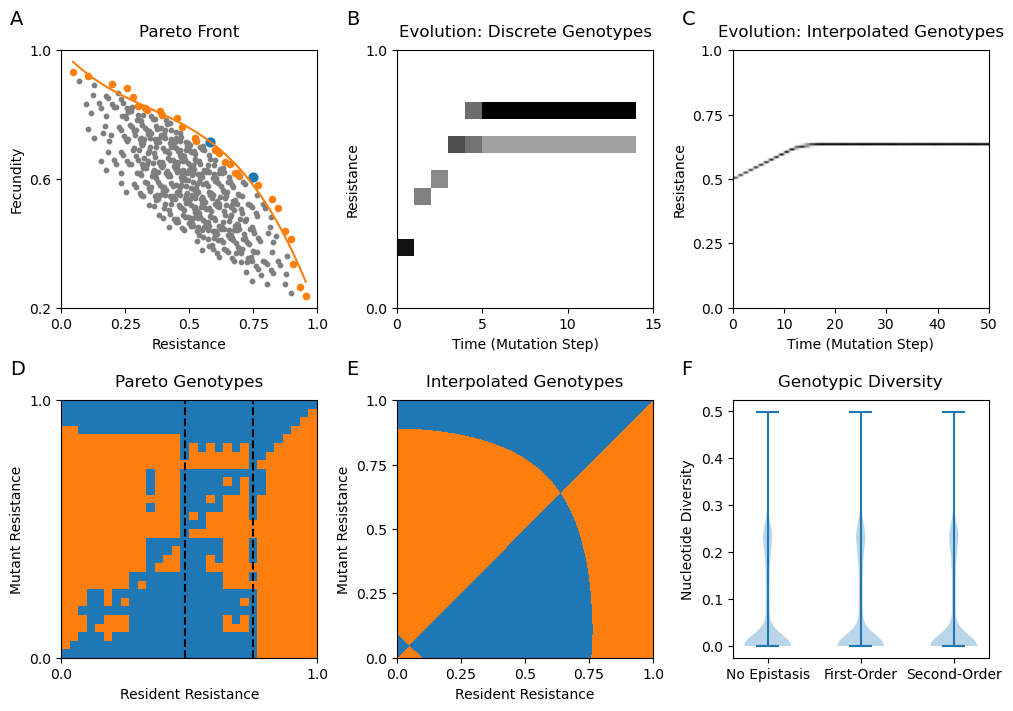

In [134]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), layout='constrained')

### Figure 3A: Genotype distribution scatterplot ###
abundances = np.max(X_t, axis=1)

ax[0,0].scatter(1-PF_model.B[abundances <= 1], PF_model.F[abundances <= 1], c='tab:gray', s=10)
ax[0,0].scatter(1-res_pareto, fec_pareto, c='tab:orange', s=20)
ax[0,0].scatter(1-PF_model.B[X_t[:,-1] > 1], PF_model.F[X_t[:,-1] > 1], c='tab:blue', s=40)

ax[0,0].plot(1-res_cubic, fec_cubic, color='tab:orange')

ax[0,0].set_title('Pareto Front', pad=10)
ax[0,0].set_ylabel('Fecundity')
ax[0,0].set_xlabel('Resistance')

label_x_ticks(ax[0,0], (0, 0.25, 0.5, 0.75, 1), 5)
label_y_ticks(ax[0,0], PF_model.F, 3)

### Figure 3B: Discrete random loci evolution plot ###
genotypes = ax[0,1].imshow(np.log(1+evol_plot), cmap='Greys', aspect='auto')
ax[0,1].set_title('Evolution: Discrete Genotypes', pad=10)
ax[0,1].set_ylabel('Resistance')
ax[0,1].set_xlabel('Time (Mutation Step)')

x_lim = ax[0,1].get_xlim()
x_ticks = np.linspace(x_lim[0], x_lim[1], 4)
x_tick_labels = ['0', '5', '10', '15']
ax[0,1].set_xticks(x_ticks, x_tick_labels)

label_y_ticks(ax[0,1], (0,1), 2)

### Figure 3C: Numerical adaptive dynamics plot ###
ax[0,2].imshow(results[0], extent=[0,1,0,1], cmap='Greys', aspect='auto')
ax[0,2].set_title('Evolution: Interpolated Genotypes', pad=10)
ax[0,2].set_ylabel('Resistance')
ax[0,2].set_xlabel('Time (Mutation Step)')

x_lim = ax[0,2].get_xlim()
x_ticks = np.linspace(x_lim[0], x_lim[1], 6)
x_tick_labels = ['0', '10', '20', '30', '40', '50']
ax[0,2].set_xticks(x_ticks, x_tick_labels)

label_y_ticks(ax[0,2], (0, 0.25, 0.5, 0.75, 1), 5)

cmap = matplotlib.colors.ListedColormap(['tab:blue','tab:orange'])

### Figure 3D: PIP plot for the pareto front genotypes ###
ax[1,0].imshow(PIP_pareto.T, cmap=cmap, aspect='auto')
ax[1,0].invert_xaxis()

for ind in np.where(X_t[:,-1] > 1)[0]:
    val = np.where(PF_model.pareto()[0] == PF_model.B[ind])[0] - 2
    val = val / PIP_pareto.shape[0]

    xlims = ax[1,0].get_xlim()
    width = xlims[0] - xlims[1]
    offset = (width / PIP_pareto.shape[0]) / 2

    val_norm = (val*width) - xlims[1] + offset

    ax[1,0].axvline(val_norm, linestyle='--', color='k')

label_x_ticks(ax[1,0], (0, 1), n_ticks=2)
label_y_ticks(ax[1,0], (0,1), n_ticks=2)

ax[1,0].set_title('Pareto Genotypes', pad=10)
ax[1,0].set_xlabel(r'Resident Resistance')
ax[1,0].set_ylabel(r'Mutant Resistance')

### Figure 3E: PIP plot for the smoothed pareto front ###
ax[1,1].imshow(PIP_approx.T, cmap=cmap, aspect='auto')
ax[1,1].invert_xaxis()

label_x_ticks(ax[1,1], (0, 0.25, 0.5, 0.75, 1), 5)
label_y_ticks(ax[1,1], (0, 0.25, 0.5, 0.75, 1), 5)

ax[1,1].set_title('Interpolated Genotypes', pad=10)
ax[1,1].set_xlabel(r'Resident Resistance')
ax[1,1].set_ylabel(r'Mutant Resistance')

### Figure 3F: Violin plots of genetic diversity ###
ax[1,2].set_title('Genotypic Diversity', pad=10)
ax[1,2].violinplot((n_div_0, n_div_1, n_div_2))
ax[1,2].set_xticks([1,2,3], ['No Epistasis', 'First-Order', 'Second-Order'])
ax[1,2].set_ylabel('Nucleotide Diversity')

ax[0,0].annotate("A", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[0,1].annotate("B", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[0,2].annotate("C", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1,0].annotate("D", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1,1].annotate("E", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1,2].annotate("F", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)